2025-04-18 21:26:13.264927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745011573.509253      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745011573.577011      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Loading TORGO: 100%|██████████| 1932/1932 [00:00<00:00, 2348129.62it/s]


Data loaded Successfully!!!


Epoch 1 Train: 100%|██████████| 1337/1337 [23:13<00:00,  1.04s/batch, acc=0.6236, loss=0.8416]


Epoch 1/10  Train L: 0.8416, A: 0.6236  Val   L: 0.6104, A: 0.7464


Epoch 2 Train: 100%|██████████| 1337/1337 [23:19<00:00,  1.05s/batch, acc=0.7653, loss=0.5630]


Epoch 2/10  Train L: 0.5630, A: 0.7653  Val   L: 0.4370, A: 0.8369


Epoch 3 Train: 100%|██████████| 1337/1337 [23:23<00:00,  1.05s/batch, acc=0.8226, loss=0.4539]


Epoch 3/10  Train L: 0.4539, A: 0.8226  Val   L: 0.3856, A: 0.8422


Epoch 4 Train: 100%|██████████| 1337/1337 [23:28<00:00,  1.05s/batch, acc=0.8640, loss=0.3657]


Epoch 4/10  Train L: 0.3657, A: 0.8640  Val   L: 0.3111, A: 0.8878


Epoch 5 Train: 100%|██████████| 1337/1337 [23:30<00:00,  1.06s/batch, acc=0.8854, loss=0.3161]


Epoch 5/10  Train L: 0.3161, A: 0.8854  Val   L: 0.3509, A: 0.8751


Epoch 6 Train: 100%|██████████| 1337/1337 [23:25<00:00,  1.05s/batch, acc=0.8953, loss=0.2857]


Epoch 6/10  Train L: 0.2857, A: 0.8953  Val   L: 0.3245, A: 0.8758


Epoch 7 Train: 100%|██████████| 1337/1337 [23:25<00:00,  1.05s/batch, acc=0.9072, loss=0.2547]


Epoch 7/10  Train L: 0.2547, A: 0.9072  Val   L: 0.3065, A: 0.8983


Epoch 8 Train: 100%|██████████| 1337/1337 [23:19<00:00,  1.05s/batch, acc=0.9144, loss=0.2280]


Epoch 8/10  Train L: 0.2280, A: 0.9144  Val   L: 0.2120, A: 0.9245


Epoch 9 Train: 100%|██████████| 1337/1337 [23:31<00:00,  1.06s/batch, acc=0.9236, loss=0.2074]


Epoch 9/10  Train L: 0.2074, A: 0.9236  Val   L: 0.2119, A: 0.9252


Epoch 10 Train: 100%|██████████| 1337/1337 [23:26<00:00,  1.05s/batch, acc=0.9269, loss=0.1989]


Epoch 10/10  Train L: 0.1989, A: 0.9269  Val   L: 0.6795, A: 0.8115


Testing: 100%|██████████| 168/168 [02:56<00:00,  1.05s/it]


              precision    recall  f1-score   support

    VERY LOW       0.85      0.94      0.90       304
         LOW       1.00      0.13      0.22       254
      MEDIUM       0.75      0.97      0.85       310
        HIGH       0.82      1.00      0.90       469

    accuracy                           0.81      1337
   macro avg       0.86      0.76      0.72      1337
weighted avg       0.85      0.81      0.76      1337

Per-class acc: [0.94078947 0.12598425 0.97419355 0.99573561]


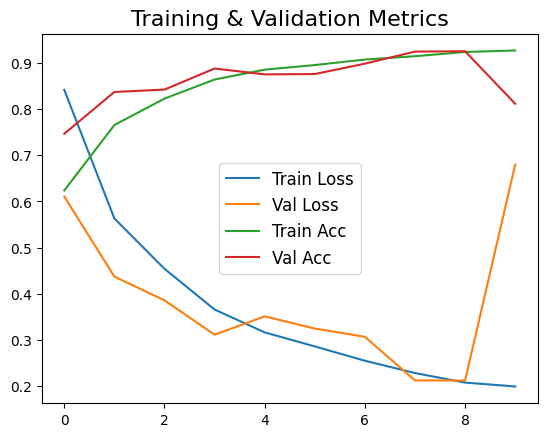

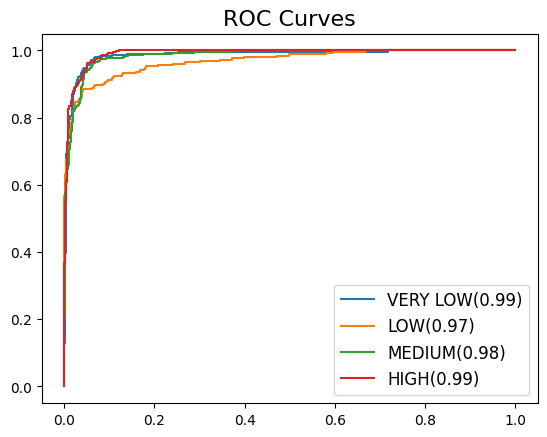

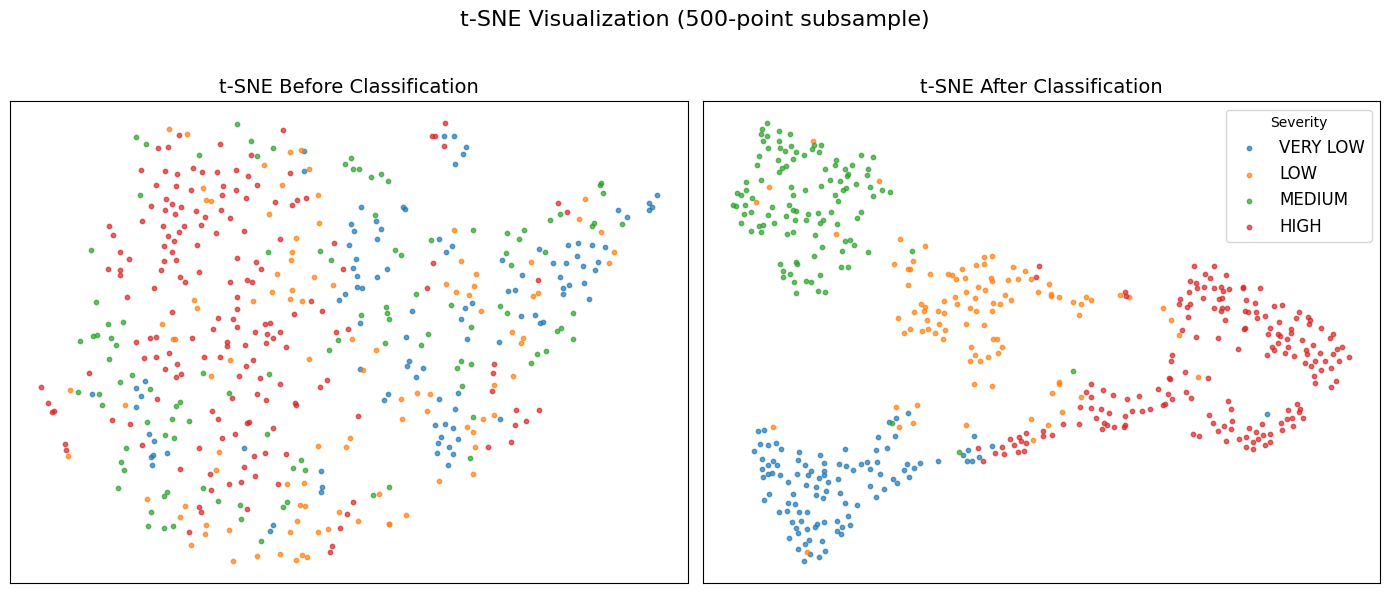

In [ ]:
import os, re, time, glob
import numpy as np
import torch, torchaudio
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from transformers import WhisperProcessor, WhisperModel
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data paths
UA_DIR     = "/kaggle/input/class-data/class-data"
TORGO_ROOT = "/kaggle/input/torgo-audio"

# load Whisper encoder
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper   = WhisperModel.from_pretrained("openai/whisper-small").to(device)
whisper.eval()
encoder   = whisper.get_encoder()

# UA dataset
class UADataset(Dataset):
    def __init__(self, root, proc, enc, max_len=1500):
        self.proc, self.enc, self.max_len = proc, enc, max_len
        self.files, self.labels = [], []
        entries = []
        for lbl in os.listdir(root):
            d = os.path.join(root, lbl)
            if not os.path.isdir(d): continue
            for wav in glob.glob(os.path.join(d, "*.wav")):
                entries.append((wav, lbl.upper()))
        for wav, lbl in tqdm(entries, desc="Loading UA"):
            self.files.append(wav)
            self.labels.append(lbl)
        self.le = LabelEncoder().fit(['VERY LOW','LOW','MEDIUM','HIGH'])
        self.labels = self.le.transform(self.labels)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        wav, sr = torchaudio.load(self.files[i])
        inp     = self.proc(wav.squeeze().numpy(), sampling_rate=sr, return_tensors="pt").input_features
        with torch.no_grad():
            out  = self.enc(input_features=inp.to(device))
            encs = out.last_hidden_state.squeeze(0)[:self.max_len]
        return encs, self.labels[i]

# TORGO dataset
torgo_map = {
    'F04':'VERY LOW','M03':'VERY LOW',
    'F01':'LOW',     'M05':'LOW',
    'M01':'MEDIUM',  'M04':'MEDIUM'
}
class TorgoDataset(Dataset):
    def __init__(self, root, proc, enc, max_len=1500):
        self.proc, self.enc, self.max_len = proc, enc, max_len
        self.files, self.labels = [], []
        pat = re.compile(r"wav_arrayMic_([A-Z]\d\d)")
        entries = []
        for grp in ['F_Dys','M_Dys']:
            dgrp = os.path.join(root, grp)
            if not os.path.isdir(dgrp): continue
            for sess in glob.glob(os.path.join(dgrp, "wav_arrayMic_*")):
                spk = pat.match(os.path.basename(sess)).group(1)
                if spk not in torgo_map: continue
                for wav in glob.glob(os.path.join(sess, "*.wav")):
                    entries.append((wav, torgo_map[spk]))
        for wav, lbl in tqdm(entries, desc="Loading TORGO"):
            self.files.append(wav)
            self.labels.append(lbl)
        self.le = LabelEncoder().fit(['VERY LOW','LOW','MEDIUM','HIGH'])
        self.labels = self.le.transform(self.labels)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        wav, sr = torchaudio.load(self.files[i])
        inp     = self.proc(wav.squeeze().numpy(), sampling_rate=sr, return_tensors="pt").input_features
        with torch.no_grad():
            out  = self.enc(input_features=inp.to(device))
            encs = out.last_hidden_state.squeeze(0)[:self.max_len]
        return encs, self.labels[i]

# build and combine datasets
ua_ds    = UADataset(UA_DIR, processor, encoder)
torgo_ds = TorgoDataset(TORGO_ROOT, processor, encoder)
full_ds  = ConcatDataset([ua_ds, torgo_ds])

# extract labels quickly
labels_all = list(ua_ds.labels) + list(torgo_ds.labels)
idxs       = list(range(len(full_ds)))

# stratified 80/10/10 split
train_idx, temp_idx = train_test_split(
    idxs, test_size=0.20, stratify=labels_all, random_state=42
)
labels_temp = [labels_all[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, stratify=labels_temp, random_state=42
)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)

# collate fn
def collate_fn(batch):
    X, y = zip(*batch)
    M    = max(x.size(0) for x in X)
    Xp   = torch.stack([torch.cat([x, x.new_zeros(M-x.size(0), x.size(1))]) for x in X])
    return Xp, torch.tensor(y)

# loaders
bs = 8
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False, collate_fn=collate_fn)

print("Data loaded Successfully!!!")

# CNN+LSTM model
class CNNLSTM(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, n_cls):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(in_dim,  64, 3, padding=1)
        self.conv2 = torch.nn.Conv1d(64,   128,3, padding=1)
        self.pool  = torch.nn.MaxPool1d(2)
        self.relu  = torch.nn.ReLU()
        self.lstm  = torch.nn.LSTM(128, hid_dim, batch_first=True)
        self.fc    = torch.nn.Linear(hid_dim, n_cls)
    def _encode(self, x):
        x = x.transpose(1,2)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.transpose(1,2)
        out, (h,_) = self.lstm(x)
        return self.fc(h[-1]), h[-1]
    def forward(self, x):
        logits, _ = self._encode(x)
        return logits
    def extract_features(self, x):
        _, feats = self._encode(x)
        return feats

model     = CNNLSTM(768, 128, 4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# training & validation
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
num_epochs = 10

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss, running_correct, running_n = 0.0, 0, 0

    # create one bar for this epoch
    total_batches = len(train_loader)
    pbar = tqdm(total=total_batches, desc=f"Epoch {epoch} Train", unit="batch")

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        running_loss    += loss.item() * X.size(0)
        running_correct += (preds == y).sum().item()
        running_n       += y.size(0)

        # update bar
        avg_loss = running_loss / running_n
        avg_acc  = running_correct / running_n
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.4f}")
        pbar.update(1)

    pbar.close()

    epoch_train_loss = running_loss / running_n
    epoch_train_acc  = running_correct / running_n
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # validation (no bar)
    model.eval()
    val_loss, val_corr, val_n = 0.0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y    = X.to(device), y.to(device)
            logits  = model(X)
            loss    = criterion(logits, y)
            preds   = logits.argmax(1)
            val_loss  += loss.item() * X.size(0)
            val_corr  += (preds == y).sum().item()
            val_n     += y.size(0)

    epoch_val_loss = val_loss / val_n
    epoch_val_acc  = val_corr / val_n
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(
        f"Epoch {epoch}/{num_epochs}  "
        f"Train L: {epoch_train_loss:.4f}, A: {epoch_train_acc:.4f}  "
        f"Val   L: {epoch_val_loss:.4f}, A: {epoch_val_acc:.4f}"
    )

# testing & feature collection
model.eval()
all_p, all_l, all_pb = [], [], []
raw_feats, post_feats, lbls = [], [], []
with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Testing"):
        X, y   = X.to(device), y.to(device)
        raw    = X.mean(dim=1).cpu().numpy()
        logits = model(X)
        probs  = torch.softmax(logits,1).cpu().numpy()
        feats  = model.extract_features(X).cpu().numpy()
        preds  = logits.argmax(1).cpu().numpy()

        raw_feats .extend(raw)
        post_feats.extend(feats)
        all_p     .extend(preds)
        all_l     .extend(y.cpu().numpy())
        all_pb    .extend(probs)
        lbls      .extend(y.cpu().numpy())

# metrics
print(classification_report(all_l, all_p, target_names=['VERY LOW','LOW','MEDIUM','HIGH']))
cm = confusion_matrix(all_l, all_p)
print("Per-class acc:", cm.diagonal()/cm.sum(axis=1))

# plot metrics
plt.figure()
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.plot(history['train_acc'],  label='Train Acc')
plt.plot(history['val_acc'],    label='Val Acc')
plt.title("Training & Validation Metrics", fontsize=16)
plt.legend(fontsize=12)
plt.show()

# ROC
y_bin = label_binarize(all_l, classes=[0,1,2,3])
probs = np.array(all_pb)
plt.figure()
for i,name in enumerate(['VERY LOW','LOW','MEDIUM','HIGH']):
    fpr,tpr,_ = roc_curve(y_bin[:,i], probs[:,i])
    plt.plot(fpr, tpr, label=f"{name}({auc(fpr,tpr):.2f})")
plt.title("ROC Curves",fontsize=16)
plt.legend(fontsize=12)
plt.show()

# t-SNE (500 sample)
raw_arr    = np.vstack(raw_feats)
post_arr   = np.vstack(post_feats)
labels_arr = np.array(lbls)
idxs       = np.random.choice(len(labels_arr), min(500,len(labels_arr)), replace=False)
Z_raw  = TSNE(n_components=2, init='pca', random_state=42).fit_transform(raw_arr[idxs])
Z_post = TSNE(n_components=2, init='pca', random_state=42).fit_transform(post_arr[idxs])
lab_sub = labels_arr[idxs]

label_names = ['VERY LOW','LOW','MEDIUM','HIGH']
colors      = ['tab:blue','tab:orange','tab:green','tab:red']

fig, axes = plt.subplots(1,2,figsize=(14,6))
for ax, Z, title in zip(axes, [Z_raw,Z_post], ["Before Classification","After Classification"]):
    for i,name in enumerate(label_names):
        sel = np.where(lab_sub==i)
        ax.scatter(Z[sel,0], Z[sel,1], label=name, alpha=0.7, s=10, c=colors[i])
    ax.set_title(f"t‑SNE {title}",fontsize=14)
    ax.set_xticks([]); ax.set_yticks([])
axes[1].legend(title="Severity",fontsize=12,loc='best')
plt.suptitle("t‑SNE Visualization (500‑point subsample)",fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [3]:
# --- at the end of your training/testing script ---

# 1. Save only the model’s learned parameters
torch.save(model.state_dict(), "cnn_lstm_state_dict.pth")

# 2. Or save a full checkpoint (model + optimizer + training metadata)
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, "cnn_lstm_checkpoint.pth")


In [4]:
# --- in a new script or notebook where you want to evaluate or resume training ---

# re‑instantiate the model & optimizer exactly as before
model = CNNLSTM(768, 128, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 1. If you saved only state_dict:
model.load_state_dict(torch.load("cnn_lstm_state_dict.pth"))
model.eval()   # set to inference mode

# 2. If you saved the full checkpoint:
ckpt = torch.load("cnn_lstm_checkpoint.pth")
model.load_state_dict(ckpt['model_state_dict'])
optimizer.load_state_dict(ckpt['optimizer_state_dict'])
start_epoch = ckpt['epoch'] + 1
history     = ckpt['history']
model.eval()  # or model.train() if resuming


/tmp/ipykernel_31/252809879.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_lstm_state_dict.pth"))
/tmp/ipykernel_31/252809879.py:1

CNNLSTM(
  (conv1): Conv1d(768, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [7]:
for epoch in range(1, 5+1):
    model.train()
    running_loss, running_correct, running_n = 0.0, 0, 0

    # create one bar for this epoch
    total_batches = len(train_loader)
    pbar = tqdm(total=total_batches, desc=f"Epoch {epoch} Train", unit="batch")

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        running_loss    += loss.item() * X.size(0)
        running_correct += (preds == y).sum().item()
        running_n       += y.size(0)

        # update bar
        avg_loss = running_loss / running_n
        avg_acc  = running_correct / running_n
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.4f}")
        pbar.update(1)

    pbar.close()

    epoch_train_loss = running_loss / running_n
    epoch_train_acc  = running_correct / running_n
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # validation (no bar)
    model.eval()
    val_loss, val_corr, val_n = 0.0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y    = X.to(device), y.to(device)
            logits  = model(X)
            loss    = criterion(logits, y)
            preds   = logits.argmax(1)
            val_loss  += loss.item() * X.size(0)
            val_corr  += (preds == y).sum().item()
            val_n     += y.size(0)

    epoch_val_loss = val_loss / val_n
    epoch_val_acc  = val_corr / val_n
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(
        f"Epoch {epoch+10}/{num_epochs+10}  ",
        f"Train L: {epoch_train_loss:.4f}, A: {epoch_train_acc:.4f}  ",
        f"Val   L: {epoch_val_loss:.4f}, A: {epoch_val_acc:.4f}",
    )

Epoch 1 Train: 100%|██████████| 1337/1337 [23:25<00:00,  1.05s/batch, acc=0.9348, loss=0.1838]


Epoch 11/20   Train L: 0.1838, A: 0.9348   Val   L: 0.1497, A: 0.9484


Epoch 2 Train: 100%|██████████| 1337/1337 [23:28<00:00,  1.05s/batch, acc=0.9379, loss=0.1709]


Epoch 12/20   Train L: 0.1709, A: 0.9379   Val   L: 0.2305, A: 0.9215


Epoch 3 Train: 100%|██████████| 1337/1337 [23:25<00:00,  1.05s/batch, acc=0.9392, loss=0.1641]


Epoch 13/20   Train L: 0.1641, A: 0.9392   Val   L: 0.1430, A: 0.9521


Epoch 4 Train: 100%|██████████| 1337/1337 [23:26<00:00,  1.05s/batch, acc=0.9422, loss=0.1602]


Epoch 14/20   Train L: 0.1602, A: 0.9422   Val   L: 0.1371, A: 0.9566


Epoch 5 Train: 100%|██████████| 1337/1337 [23:22<00:00,  1.05s/batch, acc=0.9455, loss=0.1542]


Epoch 15/20   Train L: 0.1542, A: 0.9455   Val   L: 0.1798, A: 0.9402


Testing: 100%|██████████| 168/168 [02:55<00:00,  1.05s/it]


              precision    recall  f1-score   support

    VERY LOW       0.86      1.00      0.92       304
         LOW       0.93      0.87      0.90       254
      MEDIUM       0.96      0.91      0.93       310
        HIGH       0.99      0.96      0.97       469

    accuracy                           0.94      1337
   macro avg       0.93      0.93      0.93      1337
weighted avg       0.94      0.94      0.94      1337

Per-class acc: [0.99671053 0.87007874 0.90645161 0.95522388]


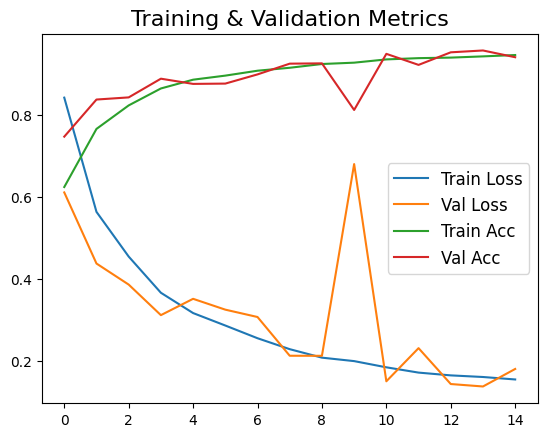

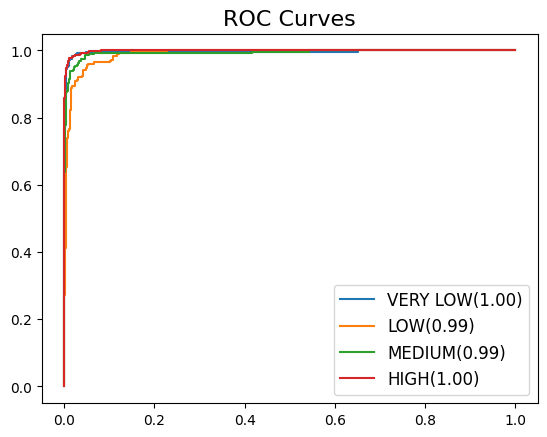

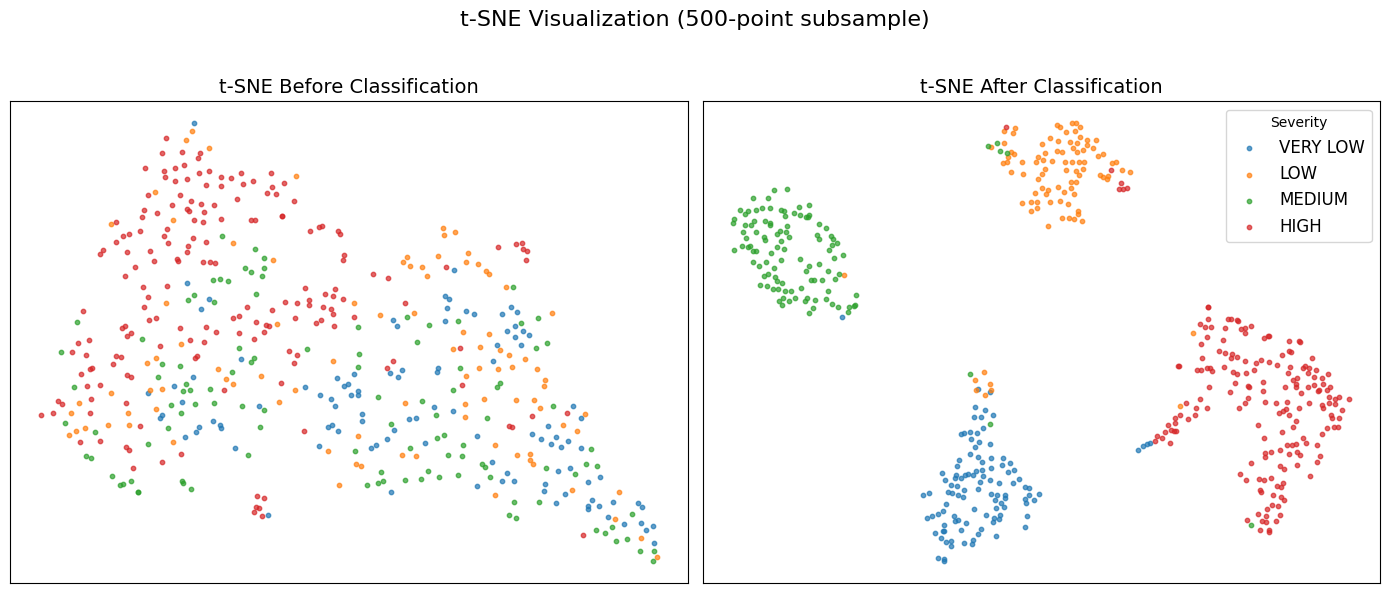

In [8]:
# testing & feature collection
model.eval()
all_p, all_l, all_pb = [], [], []
raw_feats, post_feats, lbls = [], [], []
with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Testing"):
        X, y   = X.to(device), y.to(device)
        raw    = X.mean(dim=1).cpu().numpy()
        logits = model(X)
        probs  = torch.softmax(logits,1).cpu().numpy()
        feats  = model.extract_features(X).cpu().numpy()
        preds  = logits.argmax(1).cpu().numpy()

        raw_feats .extend(raw)
        post_feats.extend(feats)
        all_p     .extend(preds)
        all_l     .extend(y.cpu().numpy())
        all_pb    .extend(probs)
        lbls      .extend(y.cpu().numpy())

# metrics
print(classification_report(all_l, all_p, target_names=['VERY LOW','LOW','MEDIUM','HIGH']))
cm = confusion_matrix(all_l, all_p)
print("Per-class acc:", cm.diagonal()/cm.sum(axis=1))

# plot metrics
plt.figure()
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.plot(history['train_acc'],  label='Train Acc')
plt.plot(history['val_acc'],    label='Val Acc')
plt.title("Training & Validation Metrics", fontsize=16)
plt.legend(fontsize=12)
plt.show()

# ROC
y_bin = label_binarize(all_l, classes=[0,1,2,3])
probs = np.array(all_pb)
plt.figure()
for i,name in enumerate(['VERY LOW','LOW','MEDIUM','HIGH']):
    fpr,tpr,_ = roc_curve(y_bin[:,i], probs[:,i])
    plt.plot(fpr, tpr, label=f"{name}({auc(fpr,tpr):.2f})")
plt.title("ROC Curves",fontsize=16)
plt.legend(fontsize=12)
plt.show()

# t-SNE (500 sample)
raw_arr    = np.vstack(raw_feats)
post_arr   = np.vstack(post_feats)
labels_arr = np.array(lbls)
idxs       = np.random.choice(len(labels_arr), min(500,len(labels_arr)), replace=False)
Z_raw  = TSNE(n_components=2, init='pca', random_state=42).fit_transform(raw_arr[idxs])
Z_post = TSNE(n_components=2, init='pca', random_state=42).fit_transform(post_arr[idxs])
lab_sub = labels_arr[idxs]

label_names = ['VERY LOW','LOW','MEDIUM','HIGH']
colors      = ['tab:blue','tab:orange','tab:green','tab:red']

fig, axes = plt.subplots(1,2,figsize=(14,6))
for ax, Z, title in zip(axes, [Z_raw,Z_post], ["Before Classification","After Classification"]):
    for i,name in enumerate(label_names):
        sel = np.where(lab_sub==i)
        ax.scatter(Z[sel,0], Z[sel,1], label=name, alpha=0.7, s=10, c=colors[i])
    ax.set_title(f"t‑SNE {title}",fontsize=14)
    ax.set_xticks([]); ax.set_yticks([])
axes[1].legend(title="Severity",fontsize=12,loc='best')
plt.suptitle("t‑SNE Visualization (500‑point subsample)",fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [10]:
# --- at the end of your training/testing script ---

# 1. Save only the model’s learned parameters
torch.save(model.state_dict(), "cnn_lstm_state_dict_2.pth")

# 2. Or save a full checkpoint (model + optimizer + training metadata)
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, "cnn_lstm_checkpoint_2.pth")


In [11]:
torch.save(model.state_dict(), "cnn_lstm_state_dict_2.keras")

In [12]:
torch.save(model.state_dict(), "cnn_lstm_state_dict_2.h5")